In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import omegaconf
import torch
import torch.optim as optim
import pandas as pd
import os,sys
sys.path.append(os.path.dirname(os.path.realpath('.')))
import mbrl.models as models
import mbrl.util.replay_buffer as replay_buffer

device = torch.device("cuda:0")

%load_ext autoreload
%autoreload 2

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'

In [7]:
os.path.realpath('.')

'/mnt/wanyao/hhf/mbrl'

In [6]:
os.path.dirname(os.path.realpath('.'))

'/mnt/wanyao/hhf/mbrl'

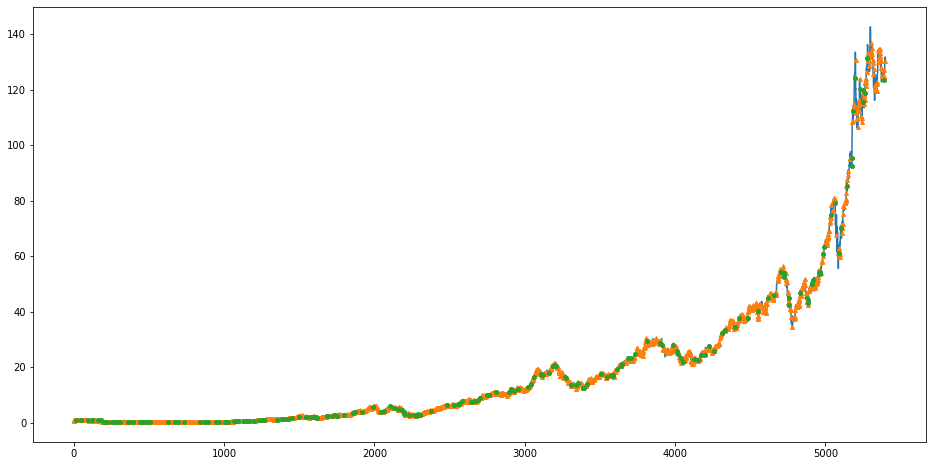

In [2]:
x_data = np.array(range(5401))
y_data=pd.read_csv("/mnt/work/project/mbrl-lib/dataset/mbrl.csv",usecols=[5])
y_data = np.array(list(y_data["close"]))


train_size = 1000
val_size = 100
x_train = np.zeros(2 * train_size)
y_train = np.zeros(2 * train_size)
x_val = np.zeros(2 * val_size)
y_val = np.zeros(2 * val_size)

# Half with lower noise
train_val_idx_1 = np.random.choice(list(range(0, 2499)), 
                                   size=train_size + val_size, 
                                   replace=False)


mag = 0.0
x_train[:train_size] = x_data[train_val_idx_1[:train_size]]
y_train[:train_size] = y_data[train_val_idx_1[:train_size]] + mag * np.random.randn(train_size)
y_val[:val_size] = y_data[train_val_idx_1[train_size:]] + mag * np.random.randn(val_size)

# Half with higher noise
train_val_idx_2 = np.random.choice(list(range(2500, 5401)), 
                                   size=train_size + val_size, 
                                   replace=False)
mag = 0.0
x_train[train_size:] = x_data[train_val_idx_2[:train_size]]
y_train[train_size:] = y_data[train_val_idx_2[:train_size]] + mag * np.random.randn(train_size)
x_val[val_size:] = x_data[train_val_idx_2[train_size:]]
y_val[val_size:] = y_data[train_val_idx_2[train_size:]] + mag * np.random.randn(val_size)

plt.figure(figsize=(16, 8))
plt.plot(x_data, y_data, x_train, y_train, '^', x_val, y_val, 'o', markersize=4)#l蓝色线：原始数据及其对应sin函数值；train对应着黄色△数据，val对应着绿色圆点数据
plt.show()

train_size *=2
val_size *= 2

In [28]:
# ReplayBuffer generates its own training/validation split, but in this example we want to
# keep the split generated above, so instead we use two replay buffers. 

num_members = 5
train_buffer = replay_buffer.ReplayBuffer(train_size, (1,), (0,))
val_buffer = replay_buffer.ReplayBuffer(val_size, (1,), (0,))
for i in range(train_size):
    train_buffer.add(x_train[i], 0, y_train[i], 0, False)
for i in range(val_size):
    val_buffer.add(x_val[i], 0, y_val[i], 0, False)
train_dataset, _ = train_buffer.get_iterators(
32, 0, train_ensemble=True, ensemble_size=num_members, shuffle_each_epoch=True)
val_dataset, _ = train_buffer.get_iterators(32, 0, train_ensemble=False)

In [48]:
replay_buffer

<module 'mbrl.util.replay_buffer' from '/mnt/work/project/mbrl-lib/.venv/lib/python3.7/site-packages/mbrl/util/replay_buffer.py'>

In [29]:
ensemble = models.GaussianMLP(
    1, 1, device, num_layers=3, hid_size=64, use_silu=True, ensemble_size=num_members)
wrapper = models.OneDTransitionRewardModel(ensemble, target_is_delta=False, normalize=True, learned_rewards=False)

In [30]:
wrapper.update_normalizer(train_buffer.get_all())
trainer = models.ModelTrainer(wrapper, optim_lr=0.003, weight_decay=5e-5)
train_losses, val_losses = trainer.train(train_dataset, val_dataset, num_epochs=500, patience=100)

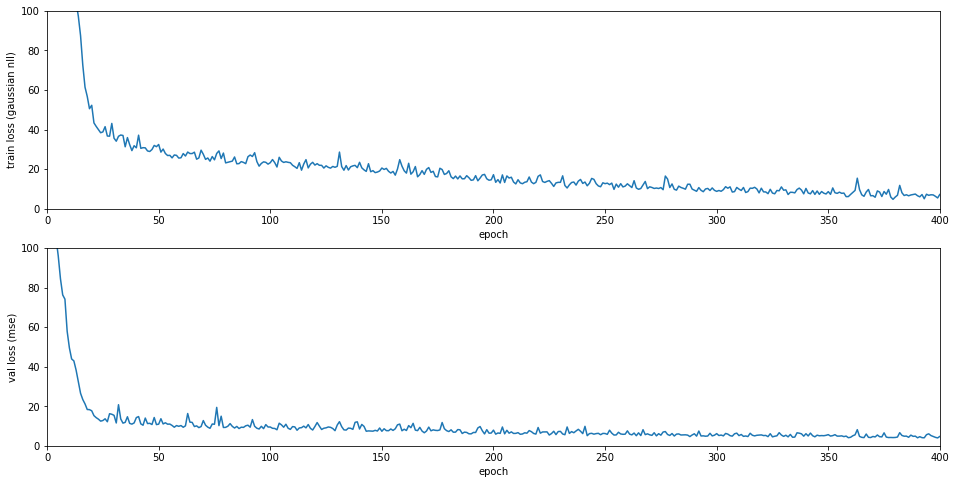

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(train_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("train loss (gaussian nll)")
ax[1].plot(val_losses)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("val loss (mse)")
ax[0].set(xlim=(0,400),ylim=(0,100))
ax[1].set(xlim=(0,400),ylim=(0,100))
plt.show()

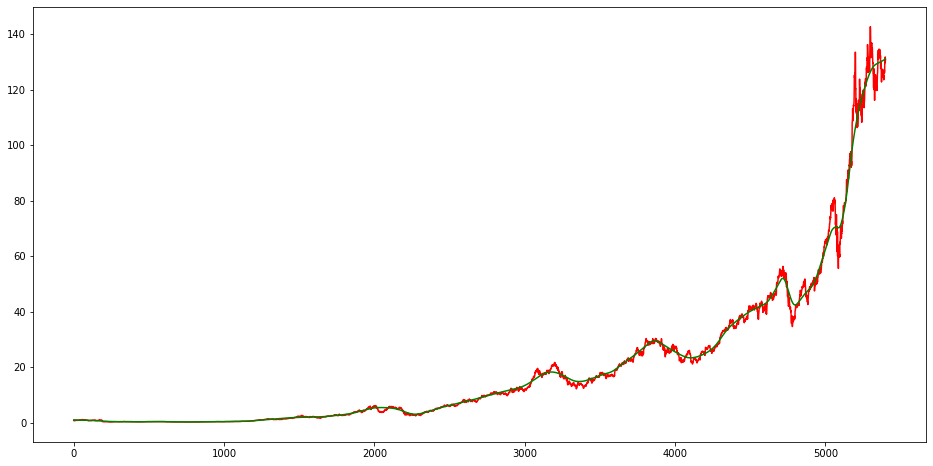

In [45]:
x_tensor = torch.from_numpy(x_data).unsqueeze(1).float().to(device)
x_tensor = wrapper.input_normalizer.normalize(x_tensor)

with torch.no_grad():
    y_pred, y_pred_logvar = ensemble(x_tensor)
    y_pred = y_pred[..., 0]
    y_pred_logvar = y_pred_logvar[..., 0]
y_var_epi = y_pred.var(dim=0).cpu().numpy()
y_var = y_pred_logvar.exp()
y_pred = y_pred.mean(dim=0).cpu().numpy()
y_var_ale = y_var.mean(dim=0).cpu().numpy()

y_std = np.sqrt(y_var_epi + y_var_ale)
plt.figure(figsize=(16, 8))
plt.plot(x_data, y_data, 'r')
plt.plot(x_data, y_pred, 'g')


In [46]:
val_losses[-1]

4.7896342277526855